In [1]:
### Code written for STDP tutorial @ CAMP 2016
### Adapted from Song et al 2000 (Competitive Hebbian Learning through spike-timing-dependent synaptic plasticity)
### With independent Poisson inputs (relevant figures : Fig 2)

### Author: Harsha Gurnani
### Date: June 15, 2016
#######################################


from brian2 import *
from time import time
%matplotlib inline

#### Simulation parameters ####
simtime = 150 *second
delta = 0.1*ms

defaultclock.dt = delta


###  Model Parameters

In [2]:
### Neuron and synapses:
#######################
taum = 20*ms                # Membrane time constant
Vrest = -70*mV              # Resting membrane potential
Erev = 0*mV                 # Excitatory synapse - reversal potential
Irev = -70*mV               # Inhibitory synapse - reversal potential
taue = 5*ms                 # Excitatory time constants
taui = 5*ms                 # Inhibitory time constants

gmax = 0.015                #Max excitatory conductance //in unnits of leak conductance
ginh = 0.05                 #Inhibitory conductance

Vt = -54*mV                 # Spike threshold
Vr = -60*mV                 # Reset potential


In [3]:
#### How does no. of synapses/ ratio influence firing rates??
Ne = 1000                   #No. of excitatory synapses
Ni = 200                    #No. of ihibitory synapses

# How does final distribution of weights depend on presynaptic firing rates? Why???
FRe = 15*Hz                 #Firing rate (FR) for excitatory input
FRi = 10*Hz                 #FR for inhibitory input


In [4]:
### Neuron model
################

eqs = Equations('''

    dV/dt = ( (Vrest - V) + ge*(Erev - V) + gi*(Irev - V) )/taum :volt
    dge/dt = -ge/taue :1        #Conductance of exc synapse
    dgi/dt = -gi/taui :1        #Conductance of inh synapse
''')

NRN = NeuronGroup(1, model=eqs, threshold = 'V>Vt', reset = 'V=Vr', method='euler')


### Synapses and STDP

In [5]:
## STDP parameters for excitatory synapses
###########################################

taupre = 20*ms          # Time constant of potentiation for pre-post pairing
taupost = 20*ms         # Time constant of depression for post-pre pairing  sudo apt-get install moose moogli
Weakratio = 1.05        # Apost*taupost/(Apre*taupre)
                        # Depression:Potentiation ratio (slightly greater than 1 for stabilising network)
Apre = 0.005            # %Strengthening with pre-post pair
Apost = Apre*(taupre/taupost)*Weakratio


In [6]:
### Excitatory Synapse Model:
#############################

'''
Synapse has a synaptic weight (gsyn) and the variables x and y.
Pre: What happens when a presynaptic spike arrives at the synapse? (Depression)
Post: What happens when the postsynaptic cell spikes? (Potentiation)
'''


In [7]:
### Poisson Input at Excitatory synapses, at firing rate FRe
InpE = PoissonGroup(Ne, rates = FRe)

S_exc = Synapses(InpE, NRN, model=syneqs, on_pre=preeqs, on_post=posteqs )
S_exc.connect()                     # Connect all
S_exc.gsyn[:] = gmax*rand(Ne)       # Initialise uniformly between 0 and gmax

In [8]:
### Inhibitory synapses:
InpI = PoissonGroup(Ni, rates = FRi)

# Constant inhibitory conductance = ginh
S_inh = Synapses(InpI, NRN, model = ' ', on_pre = '''gi_post += ginh''')
S_inh.connect()

### Monitors and run

In [9]:
VMon = StateMonitor( NRN, 'V', record = 0 )                 ## Membrane potential
FR = PopulationRateMonitor(NRN)                             ## Firing rate of NRN
Weights = StateMonitor( S_exc, 'gsyn', record = [0,Ne-1])   ## Two example synaptic weights

run( simtime, report='text')

Starting simulation at t=0. s for a duration of 150. s
3.5731 s (2%) simulated in 10s, estimated 6m 50s remaining.
7.1571 s (4%) simulated in 20s, estimated 6m 39s remaining.
10.8555 s (7%) simulated in 30s, estimated 6m 25s remaining.
14.5528 s (9%) simulated in 40s, estimated 6m 12s remaining.
18.1698 s (12%) simulated in 50s, estimated 6m 3s remaining.
21.7277 s (14%) simulated in 1m 0s, estimated 5m 54s remaining.
25.333 s (16%) simulated in 1m 10s, estimated 5m 44s remaining.
28.9558 s (19%) simulated in 1m 20s, estimated 5m 34s remaining.
32.603 s (21%) simulated in 1m 30s, estimated 5m 24s remaining.
36.2044 s (24%) simulated in 1m 40s, estimated 5m 14s remaining.
39.8372 s (26%) simulated in 1m 50s, estimated 5m 4s remaining.
43.5428 s (29%) simulated in 2m 0s, estimated 4m 53s remaining.
47.1724 s (31%) simulated in 2m 10s, estimated 4m 43s remaining.
50.8482 s (33%) simulated in 2m 20s, estimated 4m 33s remaining.
54.5391 s (36%) simulated in 2m 30s, estimated 4m 23s remainin

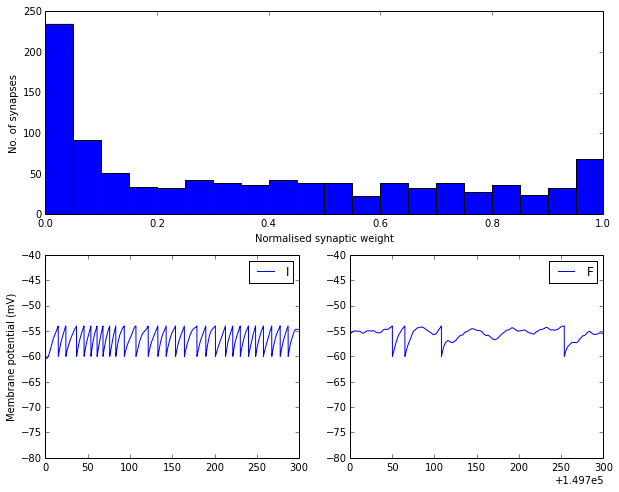

In [12]:
figure(figsize=[10,8])
### Histogram of sinal synaptic weights
subplot(211)
hist(S_exc.gsyn[:] /gmax, 20)
ylabel('No. of synapses')
xlabel('Normalised synaptic weight')

### Initial membrane potential trace
subplot(223)
plot(VMon.t[0:3000] /ms, VMon.V[0,0:3000] /mV)
ylim([-80,-40])
ylabel('Membrane potential (mV)')
legend('Initial V')

### Final membrane potential trace
subplot(224)
plot(VMon.t[-3000:-1] /ms, VMon.V[0,-3000:-1] /mV)
ylim([-80,-40])
legend('Final V')


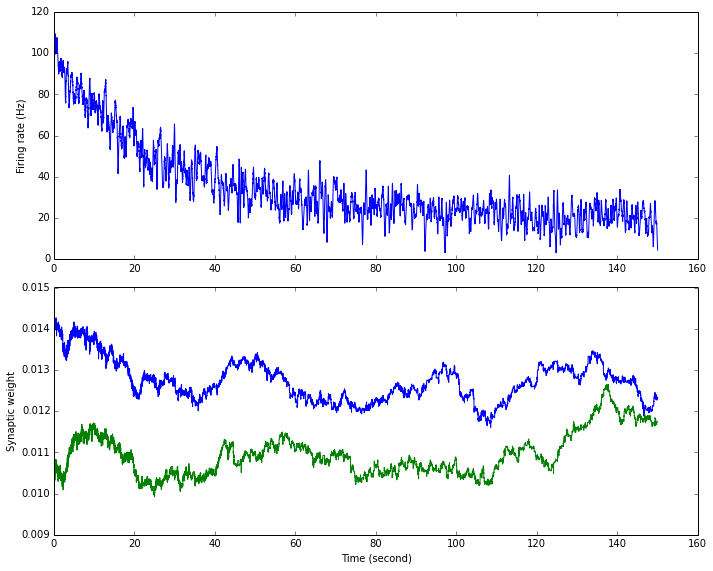

In [14]:
figure(figsize=[10,8])
### Evolution of Firing rate in time
subplot(211)
plot(FR.t /second, FR.smooth_rate(window='gaussian', width=100*ms)/Hz)
ylabel('Firing rate (Hz)')

### Evolution of two example synaptic weights
subplot(212)
plot(Weights.t /second, Weights.gsyn[0,:], 'b', label='Synapse 1')
plot(Weights.t /second, Weights.gsyn[1,:], 'g', label='Synapse N')
xlabel('Time (second)')
ylabel('Synaptic weight')

tight_layout()
